# 第7章: データベース

artist.json.gzは，オープンな音楽データベース[MusicBrainz](https://musicbrainz.org)の中で，アーティストに関するものをJSON形式に変換し，gzip形式で圧縮したファイルである．このファイルには，1アーティストに関する情報が1行にJSON形式で格納されている．

In [3]:
!head data/artist.json

{"name": "WIK▲N", "tags": [{"count": 1, "value": "sillyname"}], "sort_name": "WIK▲N", "ended": true, "gid": "8972b1c1-6482-4750-b51f-596d2edea8b1", "id": 805192}
{"name": "Gustav Ruppke", "sort_name": "Gustav Ruppke", "ended": true, "gid": "b4f76788-7e6f-41b7-ac7b-dfb67f66282e", "type": "Person", "id": 578352}
{"name": "Pete Moutso", "sort_name": "Moutso, Pete", "ended": true, "gid": "49add228-eac5-4de8-836c-d75cde7369c3", "type": "Person", "id": 371203}
{"ended": true, "gid": "c112a400-af49-4665-8bba-741531d962a1", "sort_name": "Zachary", "id": 273232, "name": "Zachary"}
{"name": "The High Level Ranters", "sort_name": "High Level Ranters, The", "ended": true, "gid": "c42eed94-e233-44e2-82b8-3ed6dd9bf318", "type": "Group", "id": 153193}
{"begin": {"year": 1956}, "end": {"year": 1993}, "name": "The Silhouettes", "area": "United States", "sort_name": "Silhouettes, The", "ended": true, "gid": "ca3f3ee1-c4a7-4bac-a16a-0b888a396c6b", "type": "Group", "id": 101060, "aliases": [{"name": "Silh

In [4]:
!wc data/artist.json -l

921337 data/artist.json


# 60. KVSの構築

Key-Value-Store (KVS) を用い，アーティスト名（name）から活動場所（area）を検索するためのデータベースを構築せよ．

- brew install leveldb
- pip install plyvel

In [22]:
import plyvel
import json

In [6]:
# make database

name_area_db = plyvel.DB('work/name_to_area.lbd', create_if_missing=True)

with open('data/artist.json') as artist_json:
    for line in artist_json:
        artist_dic = json.loads(line) # str -> dict
        
        name = artist_dic.get("name")
        area = artist_dic.get("area")
        if name and area:
            name_area_db.put(name.encode('utf-8'), area.encode('utf-8')) # str -> bytes
            
name_area_db.close()

### 登録件数の確認

# 61. KVSの検索

60で構築したデータベースを用い，特定の（指定された）アーティストの活動場所を取得せよ．



In [7]:
artist_name = 'GReeeeN'

name_area_db = plyvel.DB('work/name_to_area.lbd')
area = name_area_db.get(artist_name.encode('utf-8'))
name_area_db.close()

if area:
    print(area.decode('utf-8'))

Japan


# 62. KVS内の反復処理

60で構築したデータベースを用い，活動場所が「Japan」となっているアーティスト数を求めよ．

In [8]:
name_area_db = plyvel.DB('work/name_to_area.lbd')
count_japan = sum(1 for name, area in name_area_db 
                  if area.decode('utf-8') == 'Japan')
name_area_db.close()

In [9]:
print(count_japan)

22128


# 63. オブジェクトを値に格納したKVS

KVSを用い，アーティスト名（name）からタグと被タグ数（タグ付けされた回数）のリストを検索するためのデータベースを構築せよ．さらに，ここで構築したデータベースを用い，アーティスト名からタグと被タグ数を検索せよ．

In [10]:
!cat data/artist.json | grep 'tag' | head

{"name": "WIK▲N", "tags": [{"count": 1, "value": "sillyname"}], "sort_name": "WIK▲N", "ended": true, "gid": "8972b1c1-6482-4750-b51f-596d2edea8b1", "id": 805192}
{"rating": {"count": 1, "value": 100}, "begin": {"year": 1992}, "name": "Infester", "tags": [{"count": 1, "value": "death metal"}, {"count": 1, "value": "american"}], "sort_name": "Infester", "ended": true, "gid": "424373ba-10fc-4883-bb33-af5a1977719b", "type": "Group", "id": 407238}
{"rating": {"count": 1, "value": 100}, "begin": {"year": 1982}, "name": "Rezerwat", "area": "Poland", "tags": [{"count": 1, "value": "polish rock"}, {"count": 1, "value": "new wave"}], "sort_name": "Rezerwat", "ended": true, "gid": "f01b0f0f-cdb7-4566-8934-b0238d002b70", "type": "Group", "id": 155785}
{"name": "Anika Paris", "tags": [{"count": 1, "value": "production music"}], "sort_name": "Paris, Anika", "ended": true, "gid": "752a5dba-e08c-4d44-8f2b-af8144fe4fd6", "id": 57821}
{"name": "Baya", "area": "Denmark", "gender": "Male", "tags": [{"coun

In [11]:
import pickle

In [12]:
# make database

name_tags_db = plyvel.DB('work/name_to_tags.lbd', create_if_missing=True)
with open('data/artist.json') as artist_json:
    for line in artist_json:
        artist_dic = json.loads(line) # str -> dict
        
        name = artist_dic.get("name")
        tags = artist_dic.get("tags")
        if name and tags:
            serialized_tags = pickle.dumps(tags)
            name_tags_db.put(name.encode('utf-8'), serialized_tags)
name_tags_db.close()

In [13]:
artist_name = 'Lady Gaga'

name_tags_db = plyvel.DB('work/name_to_tags.lbd')
serialized_tags = name_tags_db.get(artist_name.encode('utf-8'))
name_tags_db.close()

if serialized_tags:
    tags = pickle.loads(serialized_tags)
    for tag in tags:
        print("{} : {}".format(tag["value"], tag["count"]))

gata rahe mera dil : 1
the fame : 1
united states : 1
américain : 1
american : 1
usa : 1
electronic : 1
electropop : 1
pop : 2
edge of glory : 1


# 64. MongoDBの構築

アーティスト情報（artist.json.gz）をデータベースに登録せよ．さらに，次のフィールドでインデックスを作成せよ: name, aliases.name, tags.value, rating.value



- brew install mongodb
- pip install pymongo
- brew services start mongodb

In [2]:
import pymongo

In [3]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
artist_db = client['artist_db']
collection = artist_db['artist_collection']

In [37]:
# make database

with open("data/artist.json") as artist_json:
    collection.insert_many(json.loads(line) for line in artist_json)

In [17]:
collection.create_index("name")
collection.create_index("aliases.name")
collection.create_index("tags.value")
collection.create_index("rating.value")

'rating.value_1'

↑
- なくても動くが、検索が早くなるらしい
- その分挿入が遅くなる
- なくても動く

In [16]:
# tqdmのおさらい
from tqdm._tqdm_notebook import tqdm
for i in tqdm(range(10)):
    print(i)

100%|██████████| 10/10 [00:00<00:00, 8694.66it/s]

0
1
2
3
4
5
6
7
8
9


### 登録件数の確認

In [18]:
%%bash
mongo
use artist_db
db.artist_collection.count()

MongoDB shell version v4.0.3
connecting to: mongodb://127.0.0.1:27017
Implicit session: session { "id" : UUID("3055cafe-ec19-418c-a38f-19d25b7e34aa") }
MongoDB server version: 4.0.3
switched to db artist_db
921337
bye


# 65. MongoDBの検索

MongoDBのインタラクティブシェルを用いて，"Queen"というアーティストに関する情報を取得せよ．さらに，これと同様の処理を行うプログラムを実装せよ．



In [4]:
%%bash
mongo
use artist_db
db.artist_collection.find({"name":"Queen"})

MongoDB shell version v4.0.3
connecting to: mongodb://127.0.0.1:27017
Implicit session: session { "id" : UUID("d065f6cd-e32a-44a3-87b0-6ca1202bd427") }
MongoDB server version: 4.0.3
switched to db artist_db
{ "_id" : ObjectId("5bcd936aab773e14a56d3695"), "name" : "Queen", "area" : "Japan", "gender" : "Female", "tags" : [ { "count" : 1, "value" : "kamen rider w" }, { "count" : 1, "value" : "related-akb48" } ], "sort_name" : "Queen", "ended" : true, "gid" : "420ca290-76c5-41af-999e-564d7c71f1a7", "type" : "Character", "id" : 701492, "aliases" : [ { "name" : "Queen", "sort_name" : "Queen" } ] }
{ "_id" : ObjectId("5bcd936bab773e14a56dfd41"), "rating" : { "count" : 24, "value" : 92 }, "begin" : { "date" : 27, "month" : 6, "year" : 1970 }, "name" : "Queen", "area" : "United Kingdom", "tags" : [ { "count" : 2, "value" : "hard rock" }, { "count" : 1, "value" : "70s" }, { "count" : 1, "value" : "queen family" }, { "count" : 1, "value" : "90s" }, { "count" : 1, "value" : "80s" }, { "count" : 1,

In [8]:
from pprint import pprint

In [9]:
for post in collection.find({'name':'Queen'}):
    pprint(post)

{'_id': ObjectId('5bcd936aab773e14a56d3695'),
 'aliases': [{'name': 'Queen', 'sort_name': 'Queen'}],
 'area': 'Japan',
 'ended': True,
 'gender': 'Female',
 'gid': '420ca290-76c5-41af-999e-564d7c71f1a7',
 'id': 701492,
 'name': 'Queen',
 'sort_name': 'Queen',
 'tags': [{'count': 1, 'value': 'kamen rider w'},
          {'count': 1, 'value': 'related-akb48'}],
 'type': 'Character'}
{'_id': ObjectId('5bcd936bab773e14a56dfd41'),
 'aliases': [{'name': '女王', 'sort_name': '女王'}],
 'area': 'United Kingdom',
 'begin': {'date': 27, 'month': 6, 'year': 1970},
 'ended': True,
 'gid': '0383dadf-2a4e-4d10-a46a-e9e041da8eb3',
 'id': 192,
 'name': 'Queen',
 'rating': {'count': 24, 'value': 92},
 'sort_name': 'Queen',
 'tags': [{'count': 2, 'value': 'hard rock'},
          {'count': 1, 'value': '70s'},
          {'count': 1, 'value': 'queen family'},
          {'count': 1, 'value': '90s'},
          {'count': 1, 'value': '80s'},
          {'count': 1, 'value': 'glam rock'},
          {'count': 4, 'valu

# 66. 検索件数の取得

MongoDBのインタラクティブシェルを用いて，活動場所が「Japan」となっているアーティスト数を求めよ．

In [46]:
%%bash
mongo
use artist_db
db.artist_collection.count({"area":"Japan"})

MongoDB shell version v4.0.3
connecting to: mongodb://127.0.0.1:27017
Implicit session: session { "id" : UUID("741fefa2-8218-4ecc-ad8d-f2143abf44f5") }
MongoDB server version: 4.0.3
switched to db artist_db
22821
bye


# 67. 複数のドキュメントの取得

特定の（指定した）別名を持つアーティストを検索せよ．

In [77]:
alias = 'Sum41'

for post in collection.find({'aliases.name':alias}):
    pprint(post)

{'_id': ObjectId('5bcd71a3ab773eb0829718a1'),
 'aliases': [{'name': 'Sum41', 'sort_name': 'Sum41'},
             {'name': 'Sum-41', 'sort_name': 'Sum-41'}],
 'area': 'Canada',
 'begin': {'year': 1996},
 'ended': True,
 'gid': 'f2eef649-a6d5-4114-afba-e50ab26254d2',
 'id': 15092,
 'name': 'Sum 41',
 'rating': {'count': 3, 'value': 73},
 'sort_name': 'Sum 41',
 'tags': [{'count': 2, 'value': 'rock'},
          {'count': 1, 'value': 'alternative rock'},
          {'count': 1, 'value': 'pop punk'},
          {'count': 3, 'value': 'punk rock'},
          {'count': 3, 'value': 'canadian'},
          {'count': 1, 'value': 'punk'},
          {'count': 1, 'value': 'canada'},
          {'count': 1, 'value': 'rock and indie'},
          {'count': 1, 'value': "scotty doesn't know"},
          {'count': 1, 'value': 'soundtrack'},
          {'count': 1, 'value': 'vgm'},
          {'count': 1, 'value': 'game'},
          {'count': 1, 'value': 'video game'}],
 'type': 'Group'}


# 68. ソート

"dance"というタグを付与されたアーティストの中でレーティングの投票数が多いアーティスト・トップ10を求めよ．



In [30]:
from itertools import islice

In [31]:
for post in islice(collection.find({"tags.value":"dance"}).sort("rating.count", -1), 10):
    print(post["name"], post["rating"])

Madonna {'count': 26, 'value': 88}
Björk {'count': 23, 'value': 84}
The Prodigy {'count': 23, 'value': 90}
Rihanna {'count': 15, 'value': 68}
Britney Spears {'count': 13, 'value': 83}
Maroon 5 {'count': 11, 'value': 60}
Adam Lambert {'count': 7, 'value': 100}
Fatboy Slim {'count': 7, 'value': 77}
Basement Jaxx {'count': 6, 'value': 83}
Cornershop {'count': 5, 'value': 68}


In [28]:
pymongo.DESCENDING

-1

# 69. Webアプリケーションの作成

ユーザから入力された検索条件に合致するアーティストの情報を表示するWebアプリケーションを作成せよ．アーティスト名，アーティストの別名，タグ等で検索条件を指定し，アーティスト情報のリストをレーティングの高い順などで整列して表示せよ．

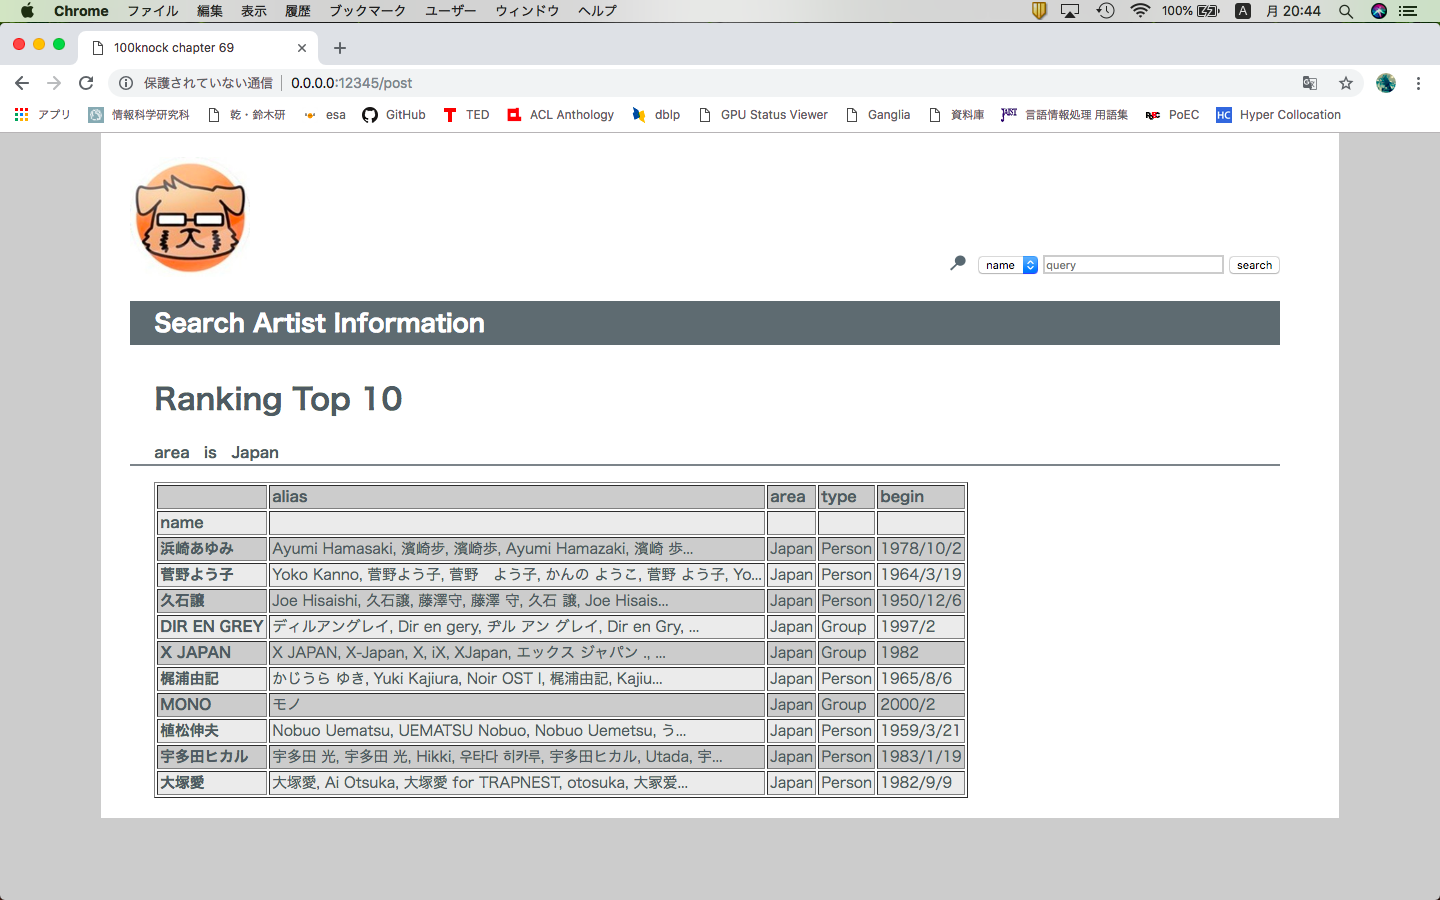

In [3]:
from IPython.display import Image
Image('work/69_web/fig.png')